# CFO Correction Network

This notebooks contains two network architectures to **learn to correct Carrier Frequency Offset (CFO)**, given preamble and preamble convolved data.

* **First Approach**: Feedforward network (~36K trainable paramters)
    * Pros: Faster inference
    * Cons: Fixed Preabmle Length
* **Second Approach**: Recurrent Neural Network network (~10K trainable paramters)
    * Pros: variable preamble length
    * Cons: Slower

## Environment Setup

### Required packages
* Tensorflow
* Keras
* Commpy
* Pydot
*  `graphviz` for visualization. `sudo apt-get install graphviz`

In [ ]:
# Import packages from other direction. Itis necessary if the project is structured as:
# my_project
# ├── notebooks
# │   └── current_notebook.ipynb
# ├── local_python_package
# │   ├── __init__.py
# │   ├── models.py
# ├── README.md
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
import numpy as np
import tensorflow as tf
from radioml.dataset import RadioData
from sklearn.metrics import mean_squared_error

# For visualization
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
sns.set_style('white')
print('TF version %s'%tf.__version__)

TF version 1.9.0


## Define Parameters for this experiment

In [2]:
DATA_LEN = 200
PREAMBLE_LEN = 40
CHANNEL_LEN = 1

SNR_TRAIN = 20.0
OMEGA_TRAIN = 1/50

## Define Data Generators for both two approaches

In [3]:
# Define Radio
radio = RadioData(data_len    =DATA_LEN, 
                  preamble_len=PREAMBLE_LEN, 
                  channels_len=CHANNEL_LEN,
                  modulation_scheme='QPSK')

training_generator   = radio.cfo_correction_data_gen(OMEGA_TRAIN, SNR_TRAIN, batch_size=128, num_cpus=8)
validation_generator = radio.cfo_correction_data_gen(OMEGA_TRAIN, SNR_TRAIN, batch_size=128, seed=2018)

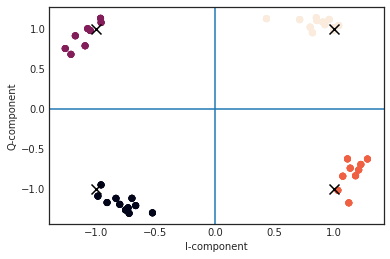

In [4]:
# Generate a few examples
examples = next(radio.cfo_correction_data_gen(OMEGA_TRAIN, SNR_TRAIN, batch_size=4, num_cpus=8))
[preambles, preambles_conv], omegas = examples
symbols, groundtruths = np.unique(preambles.view(np.complex),return_inverse=True)

plt.scatter(preambles_conv[...,0].flatten(),preambles_conv[...,1].flatten(), c=groundtruths)
plt.scatter(np.real(symbols), np.imag(symbols), marker='x', s=100, color='black')
plt.xlabel('I-component')
plt.ylabel('Q-component')
plt.axhline()
plt.axvline()

## First Approach: Feedforward Network

Number of training parameters: 36401


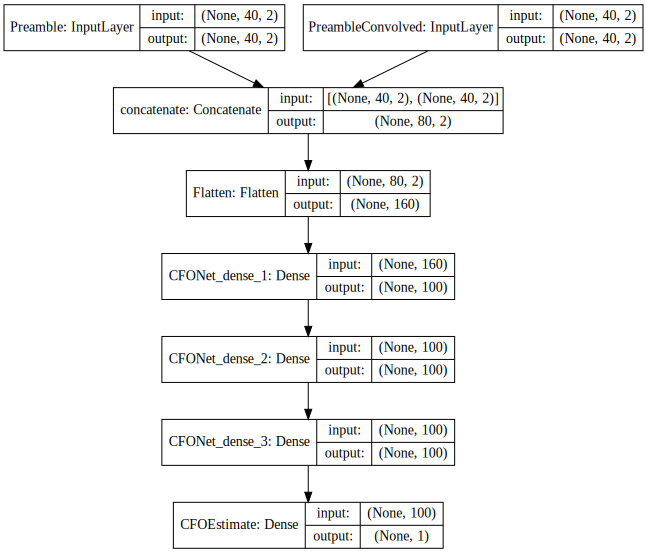

In [5]:
tf.keras.backend.clear_session()

def cfo_network(preamble, preamble_conv, scope='CFONet'):
    """
    Arguments:
        preamble :     tf.Tensor float32 -  [batch, preamble_length, 2]
        preamble_conv: tf.Tensor float32 -  [batch, preamble_length, 2]
        
    Return:
        cfo_estimate: tf.Tensor float32 - [batch_size, 1]
    """
    with tf.name_scope(scope):
        inputs = tf.keras.layers.concatenate([preamble, preamble_conv], axis=1)
        inputs = tf.keras.layers.Flatten(name='Flatten')(inputs)
        x = tf.keras.layers.Dense(100, 'selu', name=scope+"_dense_1")(inputs)
        x = tf.keras.layers.Dense(100, 'selu', name=scope+"_dense_2")(x)
        x = tf.keras.layers.Dense(100, 'selu', name=scope+"_dense_3")(x)
        
    cfo_est = tf.keras.layers.Dense(1, 'linear',name='CFOEstimate')(x)
    return cfo_est
# ############################
# Construct FeedForward Model
# ############################
# Think of keras.Input as tf.placeholder
preamble       = tf.keras.layers.Input(shape=(40, 2), name='Preamble')
preamble_conv  = tf.keras.layers.Input(shape=(40, 2), name='PreambleConvolved')
# Build tensorflow graph
omega_estimate  = cfo_network(preamble, preamble_conv)
# Instead of using TF training API, we convert Graph to tf.keras.Model.
feed_forward_model = tf.keras.Model([preamble, preamble_conv], omega_estimate)

print("Number of training parameters: %d" % feed_forward_model.count_params())
tf.keras.utils.plot_model(feed_forward_model, "model.svg", show_shapes=True, show_layer_names=True)
SVG("model.svg")

## Second Approach: Recurrent Model

Number of training parameters: 39921


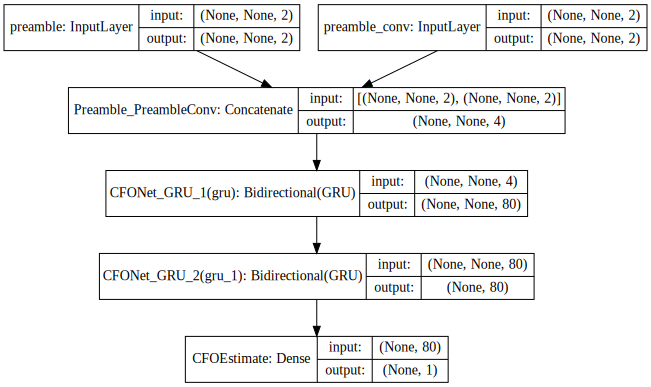

In [6]:
from tensorflow.keras.layers import Input, Bidirectional, GRU, TimeDistributed, Dense

def cfo_rnn_network(preamble, preamble_conv, scope="CFONet"):
    """
    Arguments:
        preamble :     tf.Tensor float32 -  [batch, preamble_length, 2]
        preamble_conv: tf.Tensor float32 -  [batch, preamble_length, 2]
    Return:
        cfo_est: tf.Tensor float32 - [batch_size, 1]
    """
    with tf.name_scope(scope):
        inputs = tf.keras.layers.concatenate([preamble, preamble_conv], axis=-1, 
                                             name='Preamble_PreambleConv')
        x = Bidirectional(GRU(40, 'selu', return_sequences=True), name=scope+"_GRU_1")(inputs)
        x = Bidirectional(GRU(40, 'selu', return_sequences=False),name=scope+"_GRU_2")(x)
        cfo_est = Dense(1, 'linear', name='CFOEstimate')(x)
    return cfo_est

# ############################
# Construct Recurrent Model
# ############################
preamble        = Input(shape=(None, 2), name='preamble')
preamble_conv   = Input(shape=(None, 2), name='preamble_conv')
omega_estimate  = cfo_rnn_network(preamble, preamble_conv)
recurrent_model = tf.keras.Model([preamble, preamble_conv], omega_estimate)
print("Number of training parameters: %d" % recurrent_model.count_params())
tf.keras.utils.plot_model(recurrent_model, "model.svg", show_shapes=True, show_layer_names=True)
SVG("model.svg")

## Training models

In [7]:
feed_forward_model.compile('adam','mse')
history = feed_forward_model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    steps_per_epoch=1000,
    validation_steps=100,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('nn.hdf5', save_best_only=True)],
    epochs=50, 
    workers=8)

Epoch 1/50
1000/1000 [==============================] - 87s 87ms/step - loss: 0.0442 - val_loss: 0.0065
Epoch 2/50
1000/1000 [==============================] - 85s 85ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 3/50
1000/1000 [==============================] - 84s 84ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/50
1000/1000 [==============================] - 82s 82ms/step - loss: 6.3354e-04 - val_loss: 8.6373e-04
Epoch 5/50
1000/1000 [==============================] - 82s 82ms/step - loss: 4.0572e-04 - val_loss: 4.9378e-04
Epoch 6/50
1000/1000 [==============================] - 81s 81ms/step - loss: 2.1449e-04 - val_loss: 2.4154e-04
Epoch 7/50
1000/1000 [==============================] - 82s 82ms/step - loss: 2.1020e-04 - val_loss: 1.6282e-04
Epoch 8/50
1000/1000 [==============================] - 82s 82ms/step - loss: 9.7331e-05 - val_loss: 1.0196e-04
Epoch 9/50
1000/1000 [==============================] - 81s 81ms/step - loss: 7.3461e-05 - val_loss: 1.0753e-04
Epoch 10/50
1000

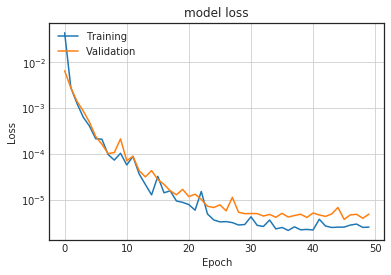

In [8]:
# Source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.grid()
plt.semilogy()
plt.show()

In [9]:
recurrent_model.compile('adam','mse')
history = recurrent_model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    steps_per_epoch=1000,
    validation_steps=100,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('rnn.hdf5', save_best_only=True)],
    epochs=40, 
    workers=8)

Epoch 1/40
1000/1000 [==============================] - 197s 197ms/step - loss: 1.8775e-04 - val_loss: 9.5487e-06
Epoch 2/40
1000/1000 [==============================] - 193s 193ms/step - loss: 1.6039e-05 - val_loss: 1.6985e-05
Epoch 3/40
1000/1000 [==============================] - 193s 193ms/step - loss: 1.4230e-05 - val_loss: 1.2338e-05
Epoch 4/40
1000/1000 [==============================] - 194s 194ms/step - loss: 1.1103e-05 - val_loss: 3.6236e-06
Epoch 5/40
1000/1000 [==============================] - 193s 193ms/step - loss: 8.3004e-06 - val_loss: 2.1326e-06
Epoch 6/40
1000/1000 [==============================] - 193s 193ms/step - loss: 7.2418e-06 - val_loss: 4.8937e-06
Epoch 7/40
1000/1000 [==============================] - 193s 193ms/step - loss: 6.1014e-06 - val_loss: 1.0933e-05
Epoch 8/40
1000/1000 [==============================] - 193s 193ms/step - loss: 4.6023e-06 - val_loss: 1.4113e-06
Epoch 9/40
1000/1000 [==============================] - 192s 192ms/step - loss: 4.4067e-

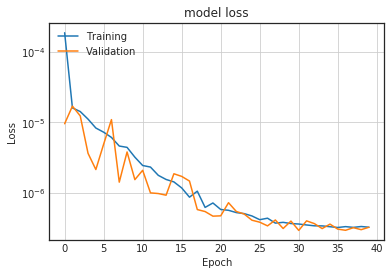

In [10]:
# Source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.grid()
plt.semilogy()
plt.show()

## Evaluate models on different Omegas and SNRs

In [11]:
# Load best trained models
feedforward = tf.keras.models.load_model('nn.hdf5')
recurrent_nn = tf.keras.models.load_model('rnn.hdf5')

radio = RadioData(data_len    =DATA_LEN, 
                  preamble_len=PREAMBLE_LEN,
                  channels_len=CHANNEL_LEN,
                  modulation_scheme='QPSK')

logs = {}
for w in [1/20, 1/50, 1/100]:
    logs[w] = []
    print('[Omega]: %f' % w)
    for snr in [10.0, 15.0, 20.0, 25.0]:
        # Define testing data
        testing_generator = radio.cfo_correction_data_gen(w, snr, batch_size=2000, seed=1111)
        test_inputs, test_labels = next(testing_generator)
        
        # Make Predictions
        rnn_predictions = recurrent_nn.predict(test_inputs)
        nn_predictions  = feedforward.predict(test_inputs)
        
        # Compute MSE
        nn_mse = mean_squared_error(test_labels, nn_predictions)
        rnn_mse =mean_squared_error(test_labels, rnn_predictions)
        
        print('\t[SNR]: %.2f || Feedforward MSE: %.8f || RecurrentNN MSE: %.8f'% (snr, nn_mse, rnn_mse))
        logs[w].append([nn_mse, rnn_mse])

[Omega]: 0.050000
	[SNR]: 10.00 || Feedforward MSE: 0.00035186 || RecurrentNN MSE: 0.00005813
	[SNR]: 15.00 || Feedforward MSE: 0.00033047 || RecurrentNN MSE: 0.00005384
	[SNR]: 20.00 || Feedforward MSE: 0.00034583 || RecurrentNN MSE: 0.00005464
	[SNR]: 25.00 || Feedforward MSE: 0.00039038 || RecurrentNN MSE: 0.00006298
[Omega]: 0.020000
	[SNR]: 10.00 || Feedforward MSE: 0.00002103 || RecurrentNN MSE: 0.00000298
	[SNR]: 15.00 || Feedforward MSE: 0.00000765 || RecurrentNN MSE: 0.00000079
	[SNR]: 20.00 || Feedforward MSE: 0.00000363 || RecurrentNN MSE: 0.00000032
	[SNR]: 25.00 || Feedforward MSE: 0.00000241 || RecurrentNN MSE: 0.00000011
[Omega]: 0.010000
	[SNR]: 10.00 || Feedforward MSE: 0.00001959 || RecurrentNN MSE: 0.00000315
	[SNR]: 15.00 || Feedforward MSE: 0.00000824 || RecurrentNN MSE: 0.00000093
	[SNR]: 20.00 || Feedforward MSE: 0.00000349 || RecurrentNN MSE: 0.00000027
	[SNR]: 25.00 || Feedforward MSE: 0.00000242 || RecurrentNN MSE: 0.00000011


In [12]:
k= np.random.randint(0, len(test_labels) - 5)
print('K=%d'%k)
print("True CFO Rate:         ", test_labels[k:k+4])
print("RNN Estimate CFO Rate: ", rnn_predictions[k:k+4].T)
print("NN  Estimate CFO Rate: ", nn_predictions[k:k+4].T)

K=1132
True CFO Rate:          [ 0.00423616 -0.0089755  -0.00986097  0.00694419]
RNN Estimate CFO Rate:  [[ 0.00380097 -0.00906415 -0.00962862  0.00728855]]
NN  Estimate CFO Rate:  [[ 0.00452172 -0.01126731 -0.00645078  0.00623436]]


## Evaluate on longer preamble

In [13]:
radio = RadioData(data_len    =DATA_LEN, 
                  preamble_len=2*PREAMBLE_LEN,  # 80
                  channels_len=CHANNEL_LEN,
                  modulation_scheme='QPSK')
logs = {}
for w in [1/20, 1/50, 1/100]:
    logs[w] = []
    print('[Omega]: %f' % w)
    for snr in [10.0, 15.0, 20.0, 25.0]:
        # Define testing data
        testing_generator = radio.cfo_correction_data_gen(w, snr, batch_size=2000, seed=1111)
        test_inputs, test_labels = next(testing_generator)
        
        # Make Predictions
        rnn_predictions = recurrent_nn.predict(test_inputs)
        
        # Compute MSE
        rnn_mse =mean_squared_error(test_labels, rnn_predictions)
        
        print('\t[SNR]: %.2f  RecurrentNN MSE: %.8f'% (snr, rnn_mse))
        logs[w].append([nn_mse, rnn_mse])

[Omega]: 0.050000
	[SNR]: 10.00  RecurrentNN MSE: 0.00048204
	[SNR]: 15.00  RecurrentNN MSE: 0.00047271
	[SNR]: 20.00  RecurrentNN MSE: 0.00046157
	[SNR]: 25.00  RecurrentNN MSE: 0.00050037
[Omega]: 0.020000
	[SNR]: 10.00  RecurrentNN MSE: 0.00015435
	[SNR]: 15.00  RecurrentNN MSE: 0.00016503
	[SNR]: 20.00  RecurrentNN MSE: 0.00015863
	[SNR]: 25.00  RecurrentNN MSE: 0.00016708
[Omega]: 0.010000
	[SNR]: 10.00  RecurrentNN MSE: 0.00008613
	[SNR]: 15.00  RecurrentNN MSE: 0.00008456
	[SNR]: 20.00  RecurrentNN MSE: 0.00008015
	[SNR]: 25.00  RecurrentNN MSE: 0.00008193
